In [1]:
import torch
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from data.custom_dataset import uci_to_normalised_ttsplit
from models import MeanFieldBNN
from training import train

torch.set_default_dtype(torch.float64)

%load_ext autoreload
%autoreload 2

In [2]:
architecture = [8, 50, 50, 2]
scale_prior=False
likelihood_std=0.1
lr=1e-2
final_lr=3e-3
epochs = 10_000
heavy_fixed_nonzero = 1.0
light_fixed_nonzero = 5.0
train_proportion = 0.8

In [3]:
torch.manual_seed(4)

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
energy = fetch_ucirepo(id=242)
X_uci, y_uci = energy.data.features, energy.data.targets
X_train, y_train, X_test, y_test = uci_to_normalised_ttsplit(X_uci, y_uci, train_proportion=train_proportion)

FC neurons in layer 1: 8
FC neurons in layer 2: 50
FC neurons in layer 3: 50
FC neurons in layer 4: 2


100%|██████████| 10000/10000 [01:16<00:00, 131.03it/s, log posterior=tensor(-1226.8626), log likelihood=tensor(1680.9058), log prior=tensor(-2907.7684), test rmse=tensor(0.0526), test mlpp=tensor(1.2308)]


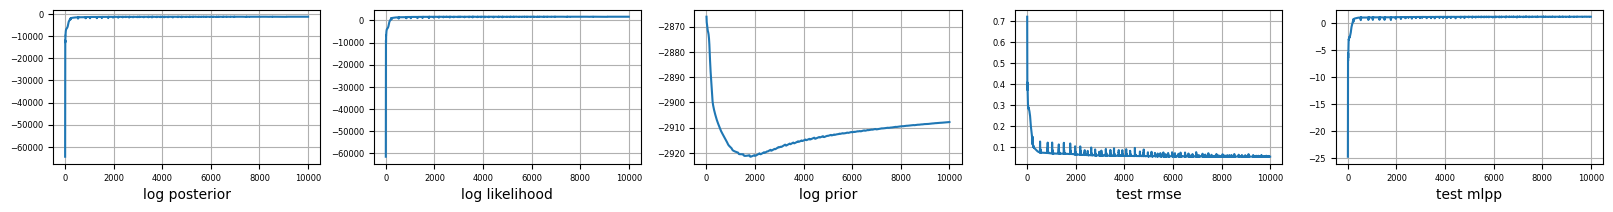

In [6]:
map_mlp = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
)
map_tracker = train(
    map_mlp,
    X_train,
    y_train,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    # batch_size=256,
    x_test=X_test,
    y_test=y_test,
)


fig, ax = plt.subplots(1, len(map_tracker.items()), figsize=(4*len(map_tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(map_tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
plt.show()

FC neurons in layer 1: 8
FC neurons in layer 2: 0
FC neurons in layer 3: 0
FC neurons in layer 4: 2


  0%|          | 0/10000 [00:00<?, ?it/s, elbo=tensor(-63616.0694), exp ll=tensor(-58991.2030), kl=tensor(4624.8664), test rmse=tensor(0.7621), test mlpp=tensor(-3.9692), c=tensor(0.9900)]

100%|██████████| 10000/10000 [04:40<00:00, 35.59it/s, elbo=tensor(-582.6618), exp ll=tensor(1017.0874), kl=tensor(1599.7492), test rmse=tensor(0.0979), test mlpp=tensor(1.0526), c=tensor(0.6356)]  


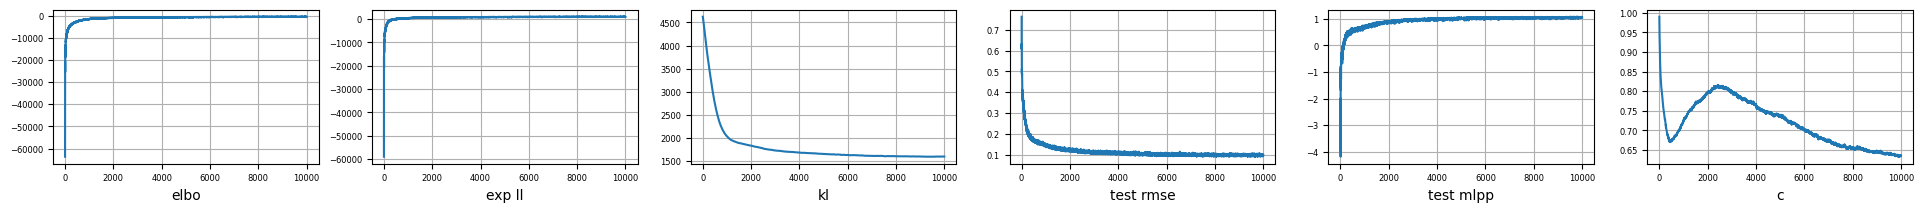

In [7]:
HAFN = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
    asymmetric_weights=True,
    minimal_mask=False,
    c=heavy_fixed_nonzero,
    train_c=True,
)

tracker = train(
    HAFN,
    X_train,
    y_train,
    variational=True,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    num_samples=16,
    x_test=X_test,
    y_test=y_test,
    batch_size=512,
)

fig, ax = plt.subplots(1, len(tracker.items()), figsize=(4*len(tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

FC neurons in layer 1: 8
FC neurons in layer 2: 0
FC neurons in layer 3: 0
FC neurons in layer 4: 2


  0%|          | 0/10000 [00:00<?, ?it/s, elbo=tensor(-633807.2873), exp ll=tensor(-626178.9245), kl=tensor(7628.3628), test rmse=tensor(2.6572), test mlpp=tensor(-394.9009), c=tensor(4.9900)]

100%|██████████| 10000/10000 [04:12<00:00, 39.56it/s, elbo=tensor(-932.5183), exp ll=tensor(699.5379), kl=tensor(1632.0561), test rmse=tensor(0.1107), test mlpp=tensor(0.9095), c=tensor(6.6906)]      


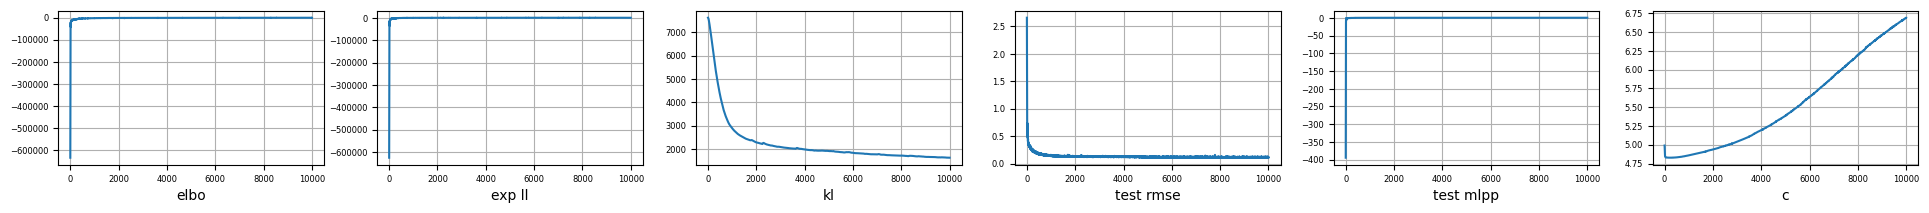

In [8]:
LAFN = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
    asymmetric_weights=True,
    minimal_mask=True,
    c=light_fixed_nonzero,
    train_c=True,
)

tracker = train(
    LAFN,
    X_train,
    y_train,
    variational=True,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    num_samples=16,
    x_test=X_test,
    y_test=y_test,
    batch_size=512,
)

fig, ax = plt.subplots(1, len(tracker.items()), figsize=(4*len(tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

FC neurons in layer 1: 8
FC neurons in layer 2: 0
FC neurons in layer 3: 0
FC neurons in layer 4: 2


  0%|          | 0/10000 [00:00<?, ?it/s, elbo=tensor(-45230.0135), exp ll=tensor(-40605.3201), kl=tensor(4624.6933), test rmse=tensor(0.7407), test mlpp=tensor(-16.4102)]

100%|██████████| 10000/10000 [04:30<00:00, 37.01it/s, elbo=tensor(-194.2926), exp ll=tensor(1089.3933), kl=tensor(1283.6859), test rmse=tensor(0.0829), test mlpp=tensor(1.0954)] 


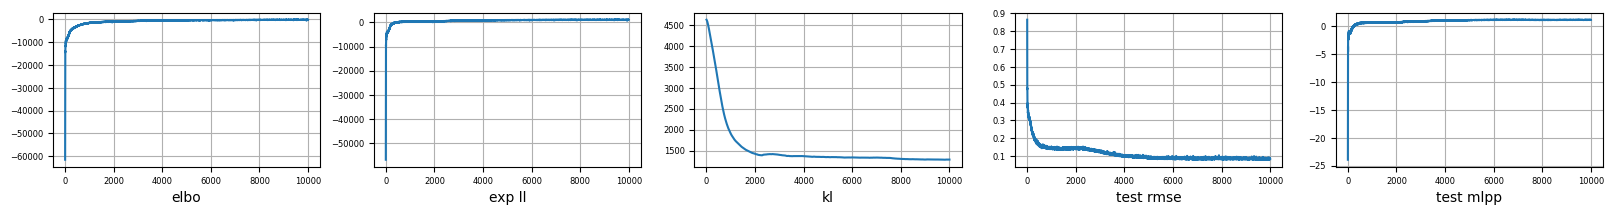

In [9]:
HApruned = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
    asymmetric_weights=True,
    minimal_mask=False,
    c=0.0,
)

tracker = train(
    HApruned,
    X_train,
    y_train,
    variational=True,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    num_samples=16,
    x_test=X_test,
    y_test=y_test,
    batch_size=512,
)

fig, ax = plt.subplots(1, len(tracker.items()), figsize=(4*len(tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

FC neurons in layer 1: 8
FC neurons in layer 2: 0
FC neurons in layer 3: 0
FC neurons in layer 4: 2


  0%|          | 0/10000 [00:00<?, ?it/s, elbo=tensor(-46694.5634), exp ll=tensor(-39067.7369), kl=tensor(7626.8264), test rmse=tensor(0.7181), test mlpp=tensor(-14.6181)]

100%|██████████| 10000/10000 [04:00<00:00, 41.53it/s, elbo=tensor(-922.6635), exp ll=tensor(425.9679), kl=tensor(1348.6314), test rmse=tensor(0.1271), test mlpp=tensor(0.6125)]   


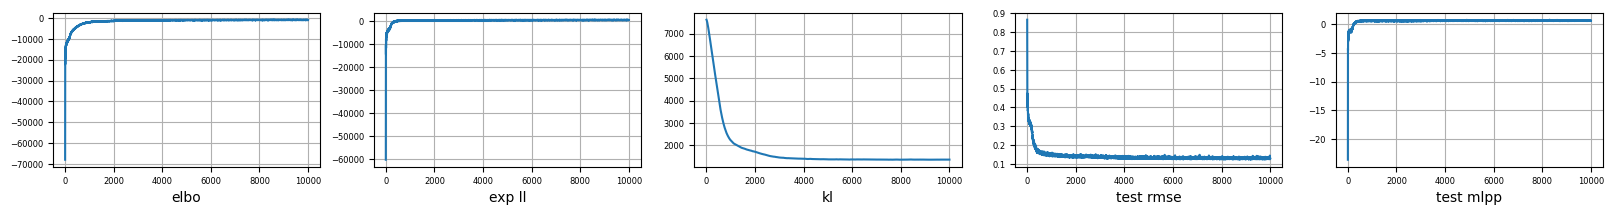

In [10]:
LApruned = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
    asymmetric_weights=True,
    minimal_mask=True,
    c=0.0,
)

tracker = train(
    LApruned,
    X_train,
    y_train,
    variational=True,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    num_samples=16,
    x_test=X_test,
    y_test=y_test,
    batch_size=512,
)

fig, ax = plt.subplots(1, len(tracker.items()), figsize=(4*len(tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

FC neurons in layer 1: 8
FC neurons in layer 2: 0
FC neurons in layer 3: 0
FC neurons in layer 4: 2


  0%|          | 0/10000 [00:00<?, ?it/s, elbo=tensor(-70278.5033), exp ll=tensor(-65649.8031), kl=tensor(4628.7002), test rmse=tensor(0.9140), test mlpp=tensor(-24.8169)]

100%|██████████| 10000/10000 [04:19<00:00, 38.50it/s, elbo=tensor(-707.8036), exp ll=tensor(435.0662), kl=tensor(1142.8698), test rmse=tensor(0.1328), test mlpp=tensor(0.5479)]   


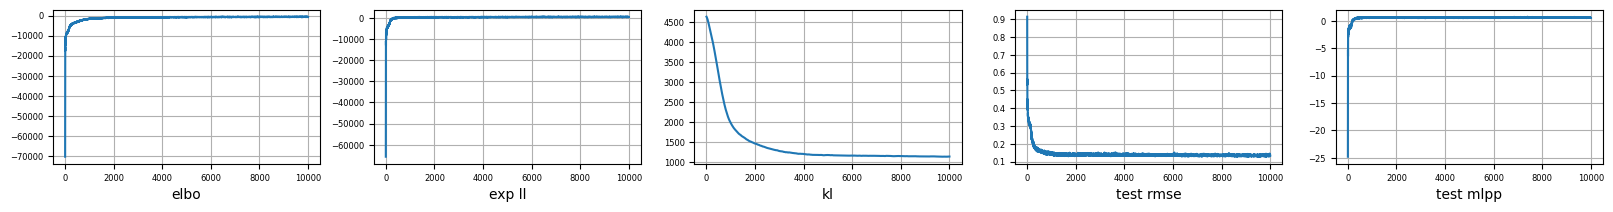

In [11]:
HAMAP = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
    asymmetric_weights=True,
    minimal_mask=False,
    map_weights=[layer.w.detach() for layer in map_mlp.layers],
)

tracker = train(
    HAMAP,
    X_train,
    y_train,
    variational=True,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    num_samples=16,
    x_test=X_test,
    y_test=y_test,
    batch_size=512,
)

fig, ax = plt.subplots(1, len(tracker.items()), figsize=(4*len(tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

FC neurons in layer 1: 8
FC neurons in layer 2: 0
FC neurons in layer 3: 0
FC neurons in layer 4: 2


100%|██████████| 10000/10000 [04:27<00:00, 37.38it/s, elbo=tensor(-630.8703), exp ll=tensor(795.7102), kl=tensor(1426.5805), test rmse=tensor(0.1137), test mlpp=tensor(0.8651)]  


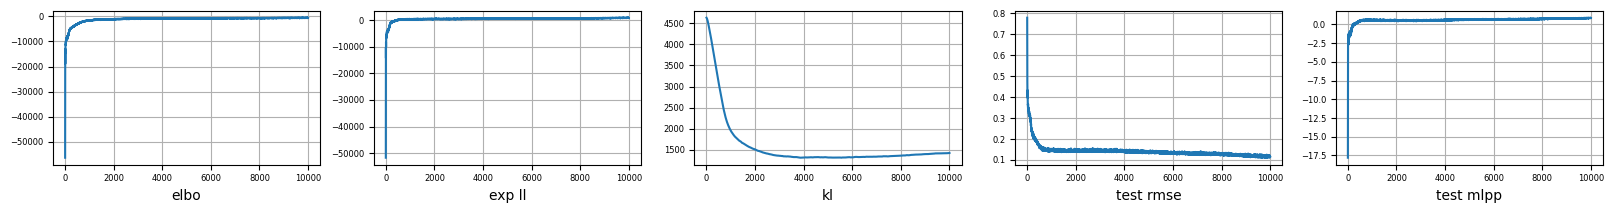

In [12]:
LAMAP = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
    asymmetric_weights=True,
    minimal_mask=False,
    map_weights=[layer.w.detach() for layer in map_mlp.layers],
)

tracker = train(
    LAMAP,
    X_train,
    y_train,
    variational=True,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    num_samples=16,
    x_test=X_test,
    y_test=y_test,
    batch_size=512,
)

fig, ax = plt.subplots(1, len(tracker.items()), figsize=(4*len(tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

FC neurons in layer 1: 8
FC neurons in layer 2: 50
FC neurons in layer 3: 50
FC neurons in layer 4: 2


100%|██████████| 10000/10000 [04:03<00:00, 41.14it/s, elbo=tensor(-785.2403), exp ll=tensor(470.2197), kl=tensor(1255.4600), test rmse=tensor(0.1373), test mlpp=tensor(0.5497)]   


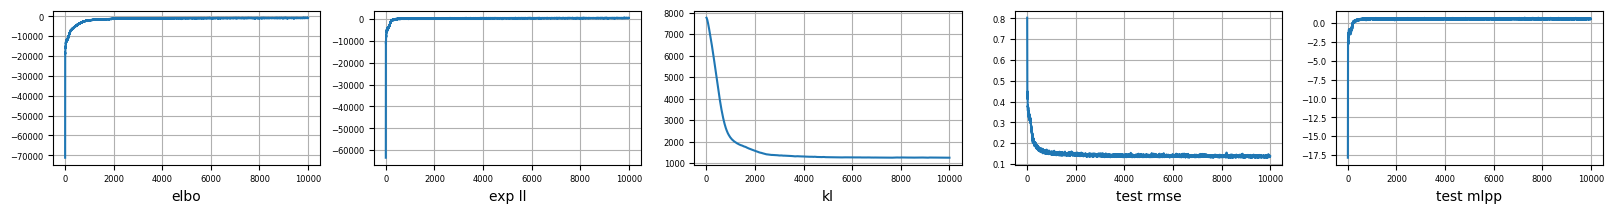

In [13]:
vanilla = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
    asymmetric_weights=False,
)

tracker = train(
    vanilla,
    X_train,
    y_train,
    variational=True,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    num_samples=16,
    x_test=X_test,
    y_test=y_test,
    batch_size=512,
)

fig, ax = plt.subplots(1, len(tracker.items()), figsize=(4*len(tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

In [14]:
num_samps = 1000
results = []
models = [
    HAFN,
    LAFN,
    HApruned,
    LApruned,
    HAMAP,
    LAMAP,
    vanilla,
]
for model in models:
    results.append(model.evaluate(X_test, y_test, variational=True, num_samples=num_samps))

titles = [
    "HAFN",
    "LAFN",
    "HApruned",
    "LApruned",
    "HAMAP",
    "LAMAP",
    "vanilla"
]

for i, result in enumerate(results):
    print(titles[i] + ":      " + "rmse=", result[0], "  mlpp=", result[1])

HAFN:      rmse= tensor(0.0967)   mlpp= tensor(1.0597)
LAFN:      rmse= tensor(0.1147)   mlpp= tensor(0.9266)
HApruned:      rmse= tensor(0.0841)   mlpp= tensor(1.0988)
LApruned:      rmse= tensor(0.1294)   mlpp= tensor(0.6865)
HAMAP:      rmse= tensor(0.1341)   mlpp= tensor(0.6590)
LAMAP:      rmse= tensor(0.1152)   mlpp= tensor(0.8872)
vanilla:      rmse= tensor(0.1347)   mlpp= tensor(0.6519)
